In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# importing the actual dataset with no missing data
iris_df = pd.read_csv('iris.csv')

# importing the dataset with 10% missing values
df=pd.read_csv('iris.mis10.csv')

# column 1 was not useful. Removed it.
del df['Unnamed: 0']

# creating a copy of df with no missing values
df_new = df.dropna().copy()

# To encode each class into a value between 1 to n_classes-1
from sklearn.preprocessing import LabelEncoder

# fitting the label encoder
encoder_obj = LabelEncoder()
df_new['C'] = encoder_obj.fit_transform(df_new['C'])

missing_SL = df[df['SL'].isna()].dropna(thresh=4)
missing_SW = df[df['SW'].isna()].dropna(thresh=4)
missing_PL = df[df['PL'].isna()].dropna(thresh=4)
missing_PW = df[df['PW'].isna()].dropna(thresh=4)

missing_SL['C'] = encoder_obj.transform(missing_SL['C'])
missing_SW['C'] = encoder_obj.transform(missing_SW['C'])
missing_PL['C'] = encoder_obj.transform(missing_PL['C'])
missing_PW['C'] = encoder_obj.transform(missing_PW['C'])

In [8]:
from sklearn.cluster import KMeans

In [9]:
scores = []

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


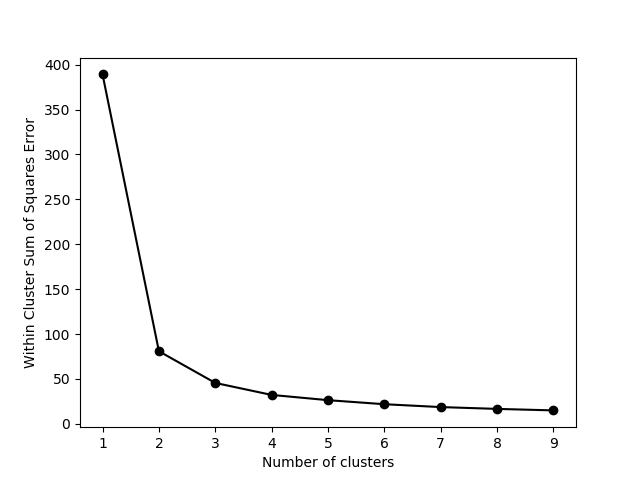

In [12]:
# Elbow method to determine optimal number of clusters for complete data set (df_new)
for i in range(1,10):
    kmeans = KMeans(n_clusters=i,n_init=10,random_state=0)
    kmeans.fit(df_new.iloc[:,:4],df_new.iloc[:,[4]])
    scores.append(kmeans.inertia_)


plt.figure()
plt.plot(np.arange(1,10),scores,'-o',c='Black')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares Error')
plt.show()

In [14]:
scores = []

<IPython.core.display.Javascript object>


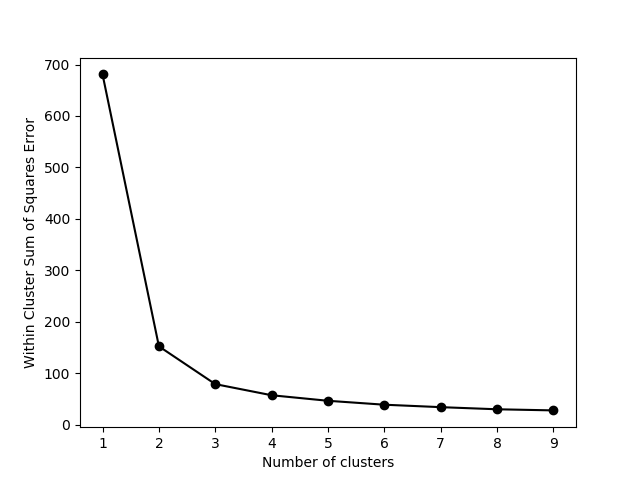

In [15]:
# Elbow method to determine optimal number of clusters for the original dataset
for i in range(1,10):
    kmeans = KMeans(n_clusters=i,n_init=10,random_state=0)
    kmeans.fit(iris_df.iloc[:,:4],iris_df.iloc[:,[4]])
    scores.append(kmeans.inertia_)

plt.figure()
plt.plot(np.arange(1,10),scores,'-o',c='Black')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares Error')
plt.show()

In [17]:
kmeans_obj = KMeans(n_clusters=3,random_state=0)

In [18]:
kmeans_obj.fit(df_new.iloc[:,:4],df_new.iloc[:,[4]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [19]:
cls_wise_stdev = np.zeros((3,4))
# cls_wise_stdev[0] = df_new
for i in range(3):
    cls_wise_stdev[i] = df_new[df_new['C'] == i].iloc[:,:4].std(axis=0)
df_new.std()
cls_wise_stdev

array([[0.36164648, 0.36195283, 0.16452649, 0.10827806],
       [0.50414945, 0.27348065, 0.46265865, 0.19515922],
       [0.61853104, 0.30121617, 0.52906897, 0.27859092]])

In [20]:
# computing class wise distance threshold between cluster centers and df_new vals
dist_threshold_i = np.zeros(3)
centroid_vals = kmeans_obj.cluster_centers_
for i in range(3):
    dist_i = []
    for j in df_new[df_new['C'] == i].values:
        dist_i.append(sum(map(lambda x : (x[0] - x[1])**2,zip(j[:4],centroid_vals[i])))**0.5)
    dist_threshold_i[i] = pd.DataFrame(dist_i).median().values
dist_threshold_i

array([3.48858604, 3.36351339, 0.81243175])

In [21]:
vals = []

In [22]:
centroid_vals

array([[5.91627907, 2.78139535, 4.47906977, 1.48139535],
       [5.03103448, 3.46206897, 1.47241379, 0.23793103],
       [6.78571429, 3.06190476, 5.67619048, 2.08571429]])

In [23]:
# imputation of missing values for SL class dataset
for i in missing_SL.values:
    cls = int(i[4])
    dist = sum(map(lambda x : (x[0] - x[1])**2,zip(i[1:4],centroid_vals[cls][1:4])))**0.5
    if dist > dist_threshold_i[cls]:
        vals.append(centroid_vals[cls][0] - cls_wise_stdev[cls][0])
    else:
        vals.append(centroid_vals[cls][0])

In [24]:
imputed_SL = missing_SL.copy()

In [25]:
imputed_SL['SL'] = vals

In [26]:
imputed_SL

,SL,SW,PL,PW,C
5,5.916279,3.9,1.7,0.4,0
11,5.916279,3.4,1.6,0.2,0
35,5.554633,3.2,1.2,0.2,0
41,5.916279,2.3,1.3,0.3,0
82,5.031034,2.7,3.9,1.2,1
109,6.785714,3.6,6.1,2.5,2
128,6.785714,2.8,5.6,2.1,2
129,6.785714,3.0,5.8,1.6,2
147,6.785714,3.0,5.2,2.0,2


In [27]:
iris_df.iloc[missing_SL.index,:]['SL']

5      5.4
11     4.8
35     5.0
41     4.5
82     5.8
109    7.2
128    6.4
129    7.2
147    6.5
Name: SL, dtype: float64

In [28]:
mean_SL = df_new[df_new['C'] == 0]

In [29]:
mean_SL['SL'].mean()

5.031034482758621

In [30]:
# decision Tree Regressor

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
dtree_clf = DecisionTreeClassifier(random_state=0)

In [33]:
dtree_clf.fit(iris_df.iloc[:,:4],encoder_obj.transform(iris_df.iloc[:,[4]]))

/home/cyberworm/miniconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [34]:
dtree_clf.predict(imputed_SL.iloc[:,:4])

array([0, 0, 0, 0, 1, 2, 2, 2, 2])

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(imputed_SL['C'],dtree_clf.predict(imputed_SL.iloc[:,:4]))

array([[4, 0, 0],
       [0, 1, 0],
       [0, 0, 4]])

<IPython.core.display.Javascript object>


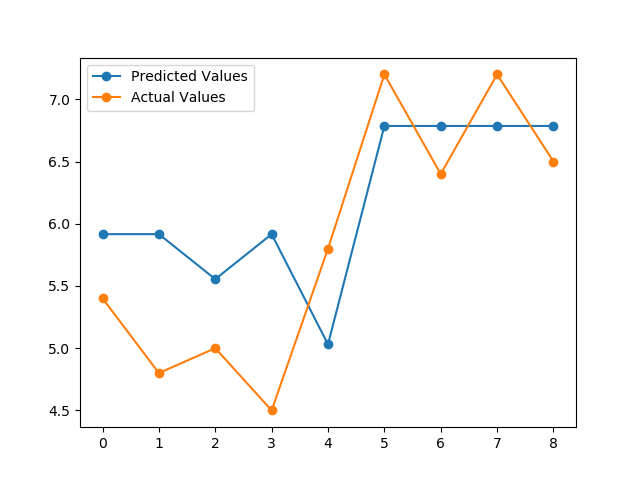

In [37]:
plt.figure()
plt.plot(np.arange(len(vals)),vals, '-o',label='Predicted Values')
plt.plot(np.arange(len(vals)),iris_df.iloc[missing_SL.index,[0]].values, '-o',label = 'Actual Values')
plt.legend()
plt.show()